In [21]:
import csv
import os
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd

In [43]:
folder_to_name = {'precocious': 'hsbam',
                  'wt1': 'wtF',
                  'wt2': 'wtJ',
                  '96h': '96h',
                  'nogerm_overexpression': 'tj_dpp',
                  'nogerm_mutant': 'bam',
                  'noovary': 'osk'
                 }
matrices_dir = "/Users/vickyle/Dropbox/Drosophila_Inferelator_Project (1)"
data_frames = {}

tech = 'cellranger'

for folder in folder_to_name:
    subfolder = folder_to_name[folder]
    matrix_dir = os.path.join(os.path.join(matrices_dir,subfolder), tech)
    mat = scipy.io.mmread(os.path.join(matrix_dir, "matrix.mtx"))
 
    genes_path = os.path.join(matrix_dir, "genes.tsv")
    gene_ids = [row[0] for row in csv.reader(open(genes_path), delimiter="\t")]
    gene_names = [row[1] for row in csv.reader(open(genes_path), delimiter="\t")]
 
    barcodes_path = os.path.join(matrix_dir, "barcodes.tsv")
    barcodes = [row[0] for row in csv.reader(open(barcodes_path), delimiter="\t")]
    arr=mat.toarray()
    df = pd.DataFrame(arr)
    df.index = gene_names
    df.columns = barcodes 
    data_frames[folder] = df

In [15]:
arr[1:100, 1:100]

array([[0, 0, 1, ..., 4, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

/Users/vickyle/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


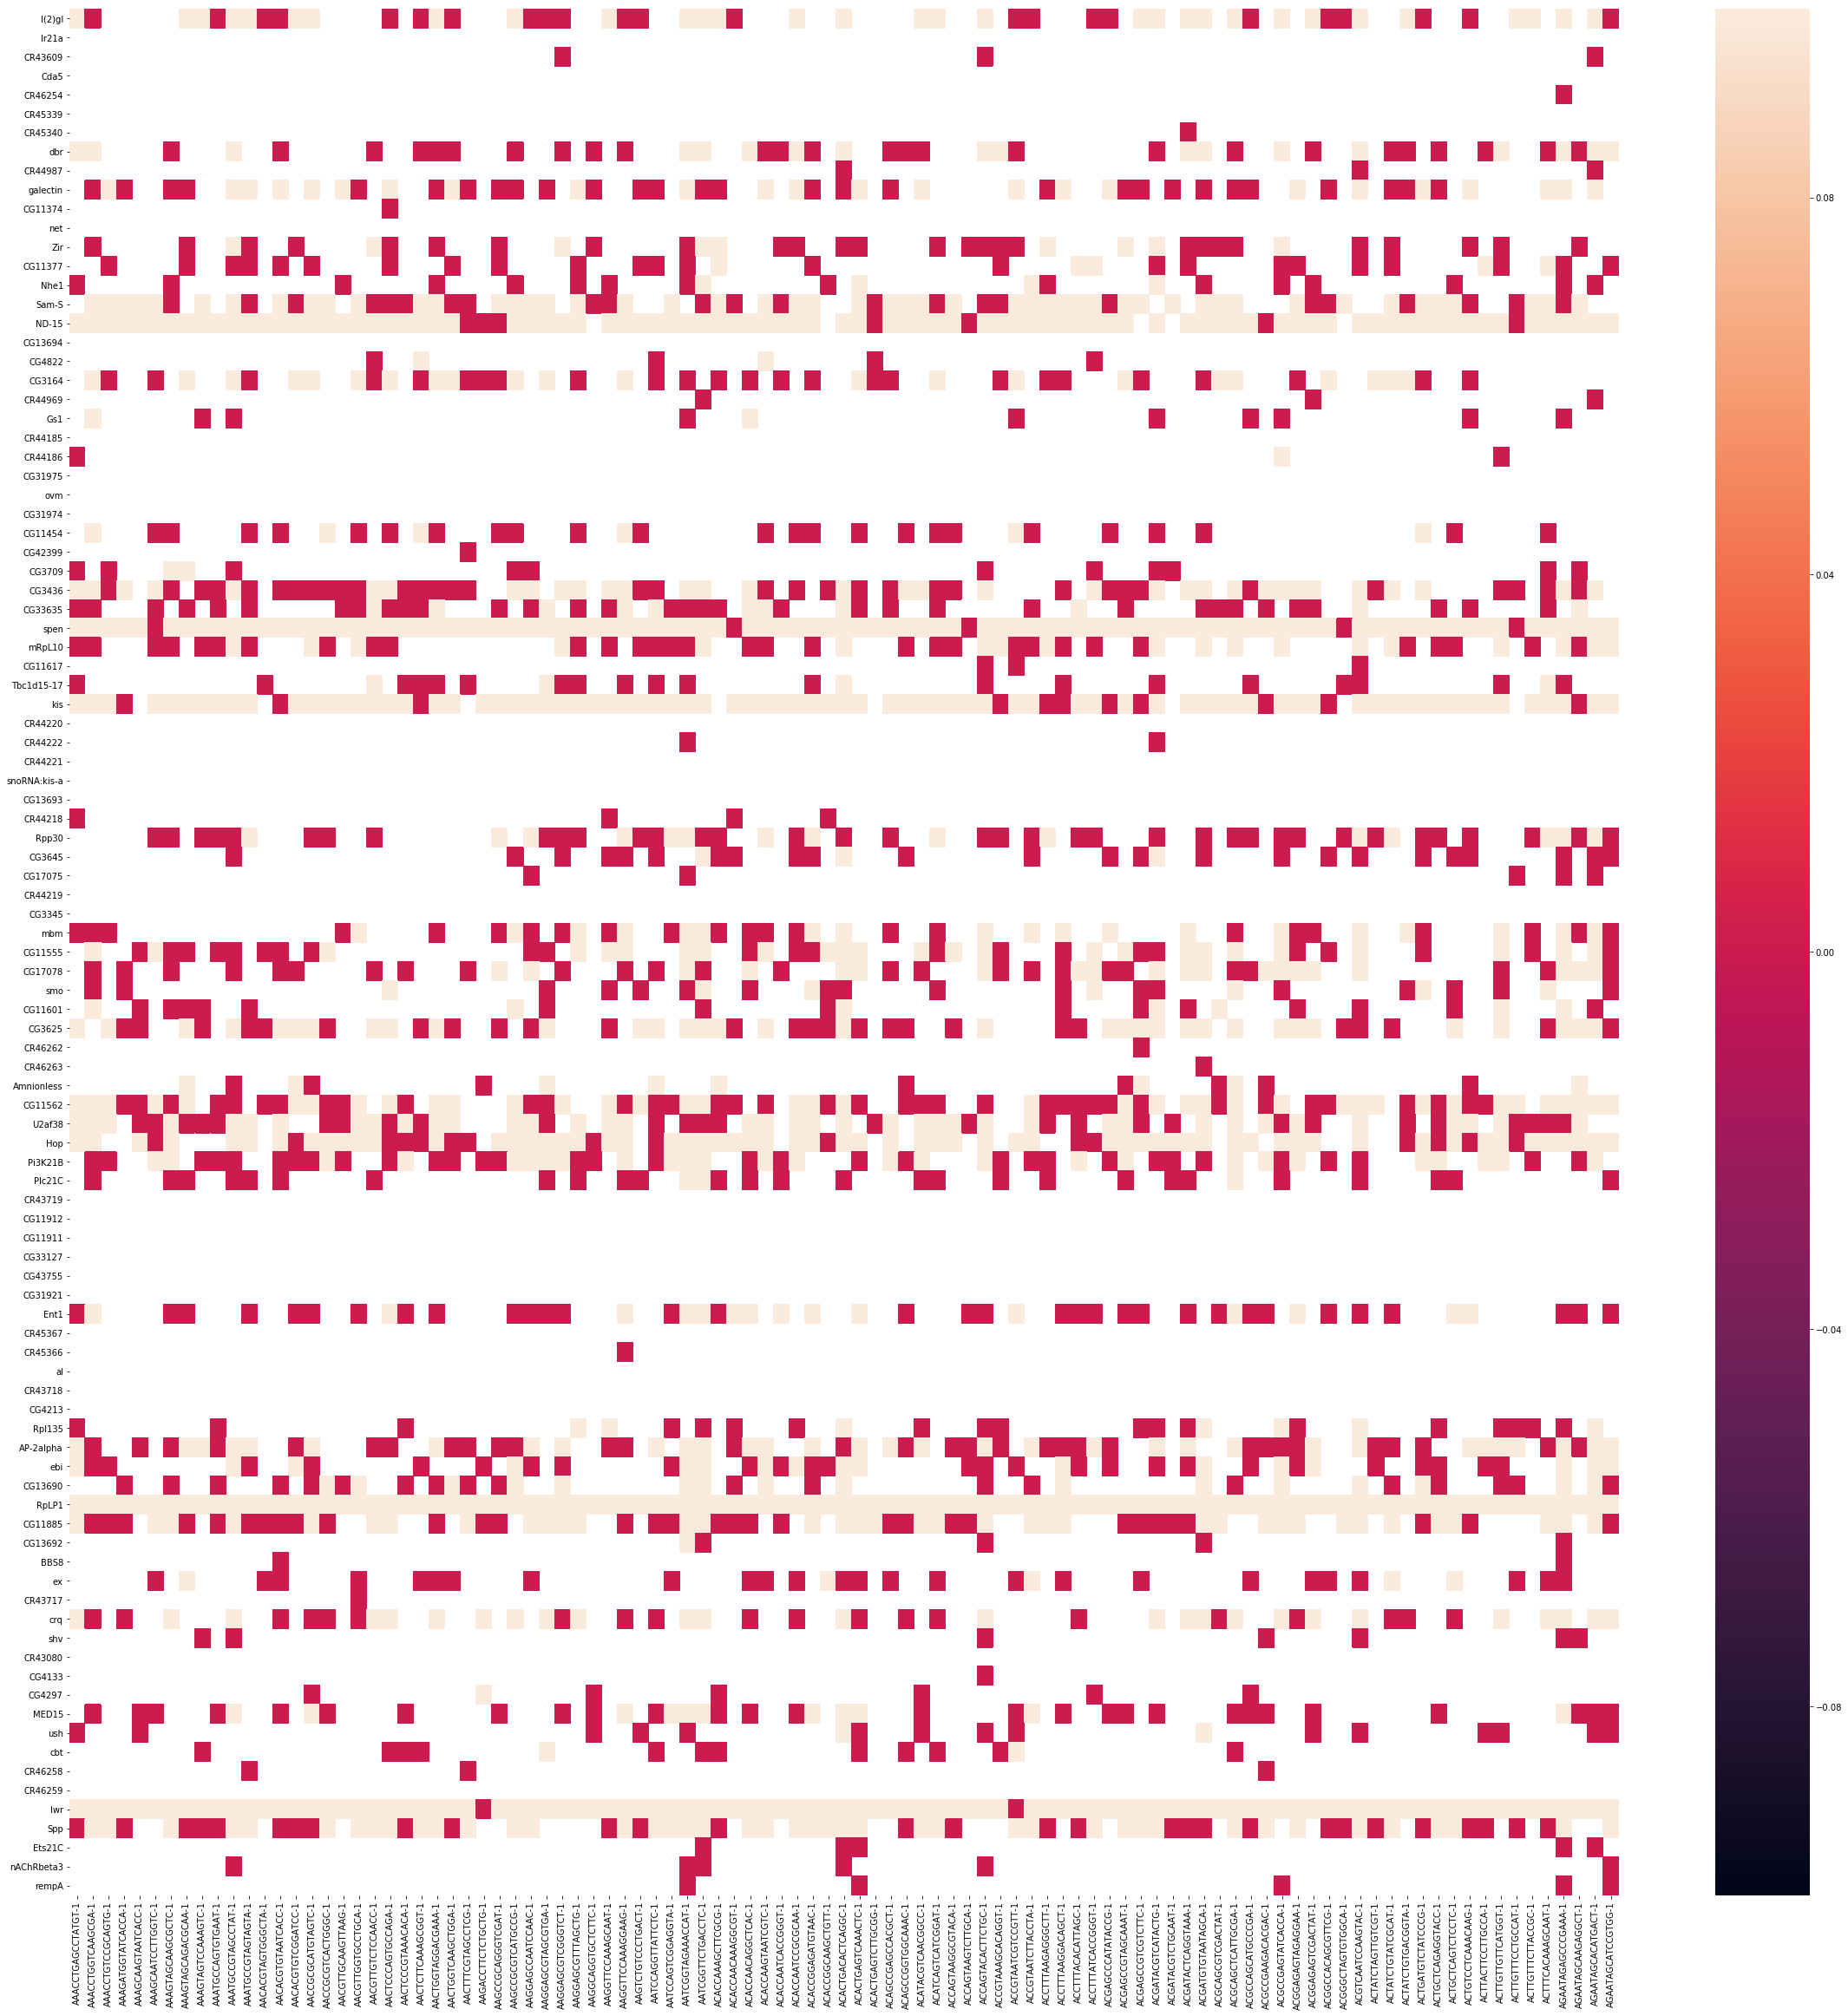

In [46]:
plt.figure(figsize=(40, 40))
sns.heatmap(np.log(data_frames['wt1'].iloc[1:100, 1:100]))

In [247]:
df_wt1 = data_frames['wt1']

In [214]:
df_wt1 = pd.DataFrame(arr)
df_wt1.index = gene_names

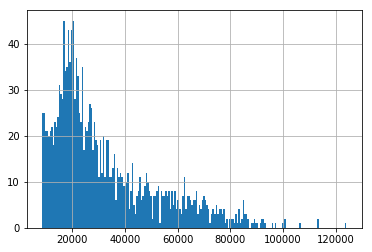

In [215]:
df_wt1.sum(axis=0).hist(bins=200)

In [216]:
df_wt1.sum(axis=0).min()

8512

## Reproducing tSNE clustering of ~7 cell types

We aim to see if all 7 dataframes can be normalized, filtered and reduced such that their dimensionality reduction clustering recaptures the 7 cell type clusterings. However, it's also possible that the mutant / overexpression data sets have fewer clusters. 

Then, we can take an intermediary data matrix, likely of the variable, normalized genes, and use that as input to the Inferelator

In [217]:
df_wt1.columns = barcodes

In [248]:
df_wt1.head()

,AAACCTGAGAGGACGG-1,AAACCTGAGCCTATGT-1,AAACCTGGTCAAGCGA-1,AAACCTGTCCGCAGTG-1,AAAGATGGTATCACCA-1,AAAGCAAGTAATCACC-1,AAAGCAATCCTTGGTC-1,AAAGTAGCAAGCGCTC-1,AAAGTAGCAGACGCAA-1,AAAGTAGTCCAAAGTC-1,...,TTGGAACTCCTTCAAT-1,TTGGAACTCTGCGACG-1,TTGTAGGCAGACACTT-1,TTTACTGAGAAGAAGC-1,TTTACTGAGGTGCAAC-1,TTTATGCGTAGAAGGA-1,TTTCCTCCACGGCCAT-1,TTTGCGCAGTACGCGA-1,TTTGCGCCATTAGGCT-1,TTTGGTTGTCCCTACT-1
CG11023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
l(2)gl,1,3,1,0,0,0,0,0,2,3,...,0,0,2,2,0,7,15,2,1,1
Ir21a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CR43609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Cda5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


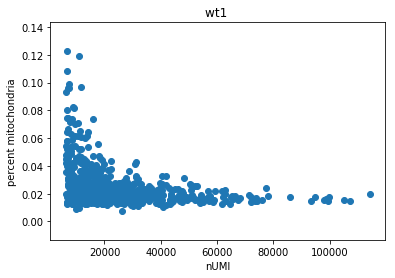

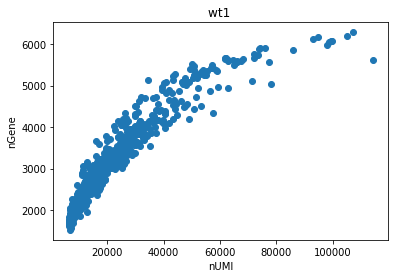

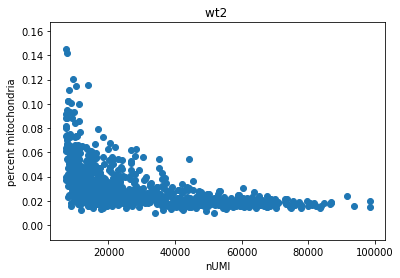

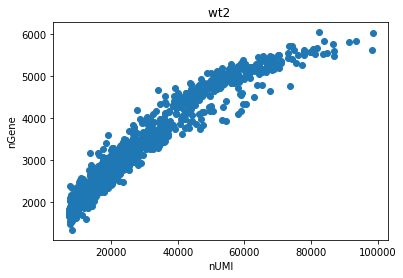

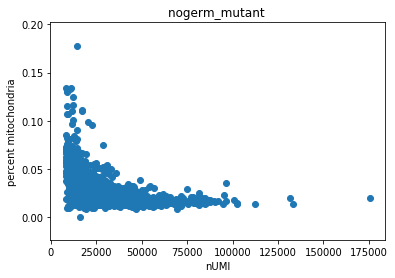

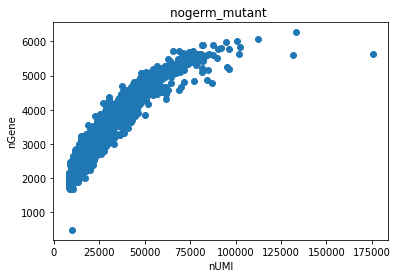

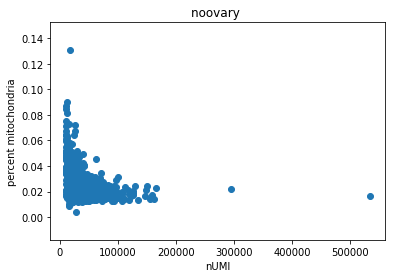

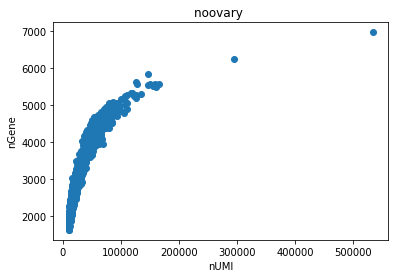

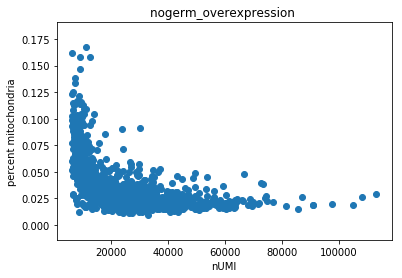

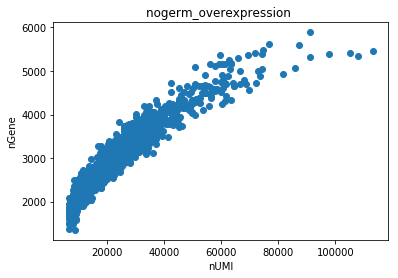

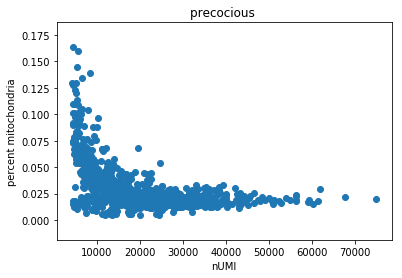

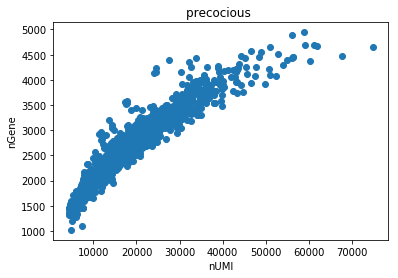

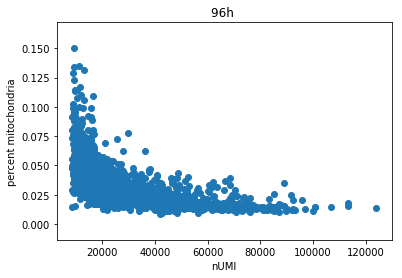

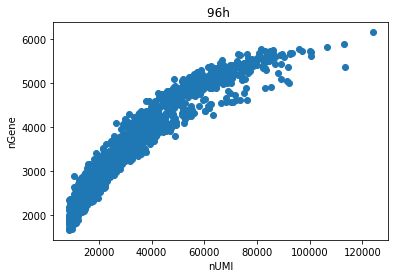

In [285]:
filtered_data_frames = {}
filtered_lengths = {}
for df_key in data_frames:
    df = data_frames[df_key]
    original_len = df.shape[1]
    mito_df = df[[x.__contains__("mt:") for x in df.index]]
    percent_mito = mito_df.sum(axis=0)/df.sum(axis = 0)
    nGene = df[df > 0].count(axis = 0)
    percent_mito_5percent = percent_mito < 0.05
    number_nGene_250 = 250 < nGene 
    number_nGene_5000 = nGene < 5000
    df_filtered = df.loc[:, percent_mito_5percent & number_nGene_5000 & number_nGene_250]
    new_len = df_filtered.shape[1]
    nUMI = df.sum(axis = 0)
    plt.scatter(nUMI, percent_mito)
    plt.xlabel('nUMI')
    plt.ylabel('percent mitochondria')
    plt.title('{} '.format(df_key))
    plt.show()
    plt.scatter(nUMI, nGene)
    plt.xlabel('nUMI')
    plt.ylabel('nGene')
    plt.title('{} '.format(df_key))
    plt.show()
    filtered_lengths[df_key] = (original_len, new_len)
    filtered_data_frames[df_key] = df_filtered

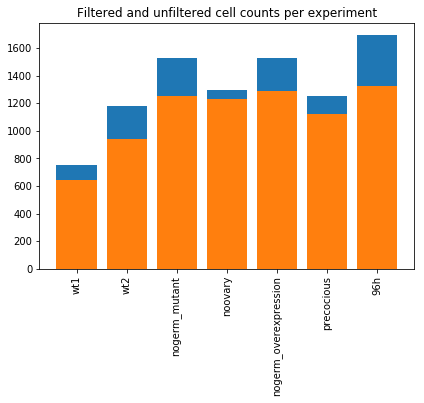

In [287]:
idx = np.arange(len(filtered_lengths))
plt.bar(idx, [x[0] for x in filtered_lengths.values()])
plt.bar(idx, [x[1] for x in filtered_lengths.values()])
plt.tight_layout()
plt.xticks(idx, filtered_lengths.keys(),  rotation='vertical')
plt.title('Filtered and unfiltered cell counts per experiment')
plt.show()


In [288]:
combined = pd.concat(filtered_data_frames.values(), join='outer', axis  =1 )


In [289]:
combined.shape

(17433, 7807)

In [296]:
scale_factor = 10000
# pseudocount added so that log isn't taken of 0
combined_transformed = np.log((combined / combined.sum() *  scale_factor) + 1)

In [302]:
combined_transformed.to_csv(os.path.join(matrices_dir, "filtered_log_transformed_merged_reads.tsv"), sep='\t')

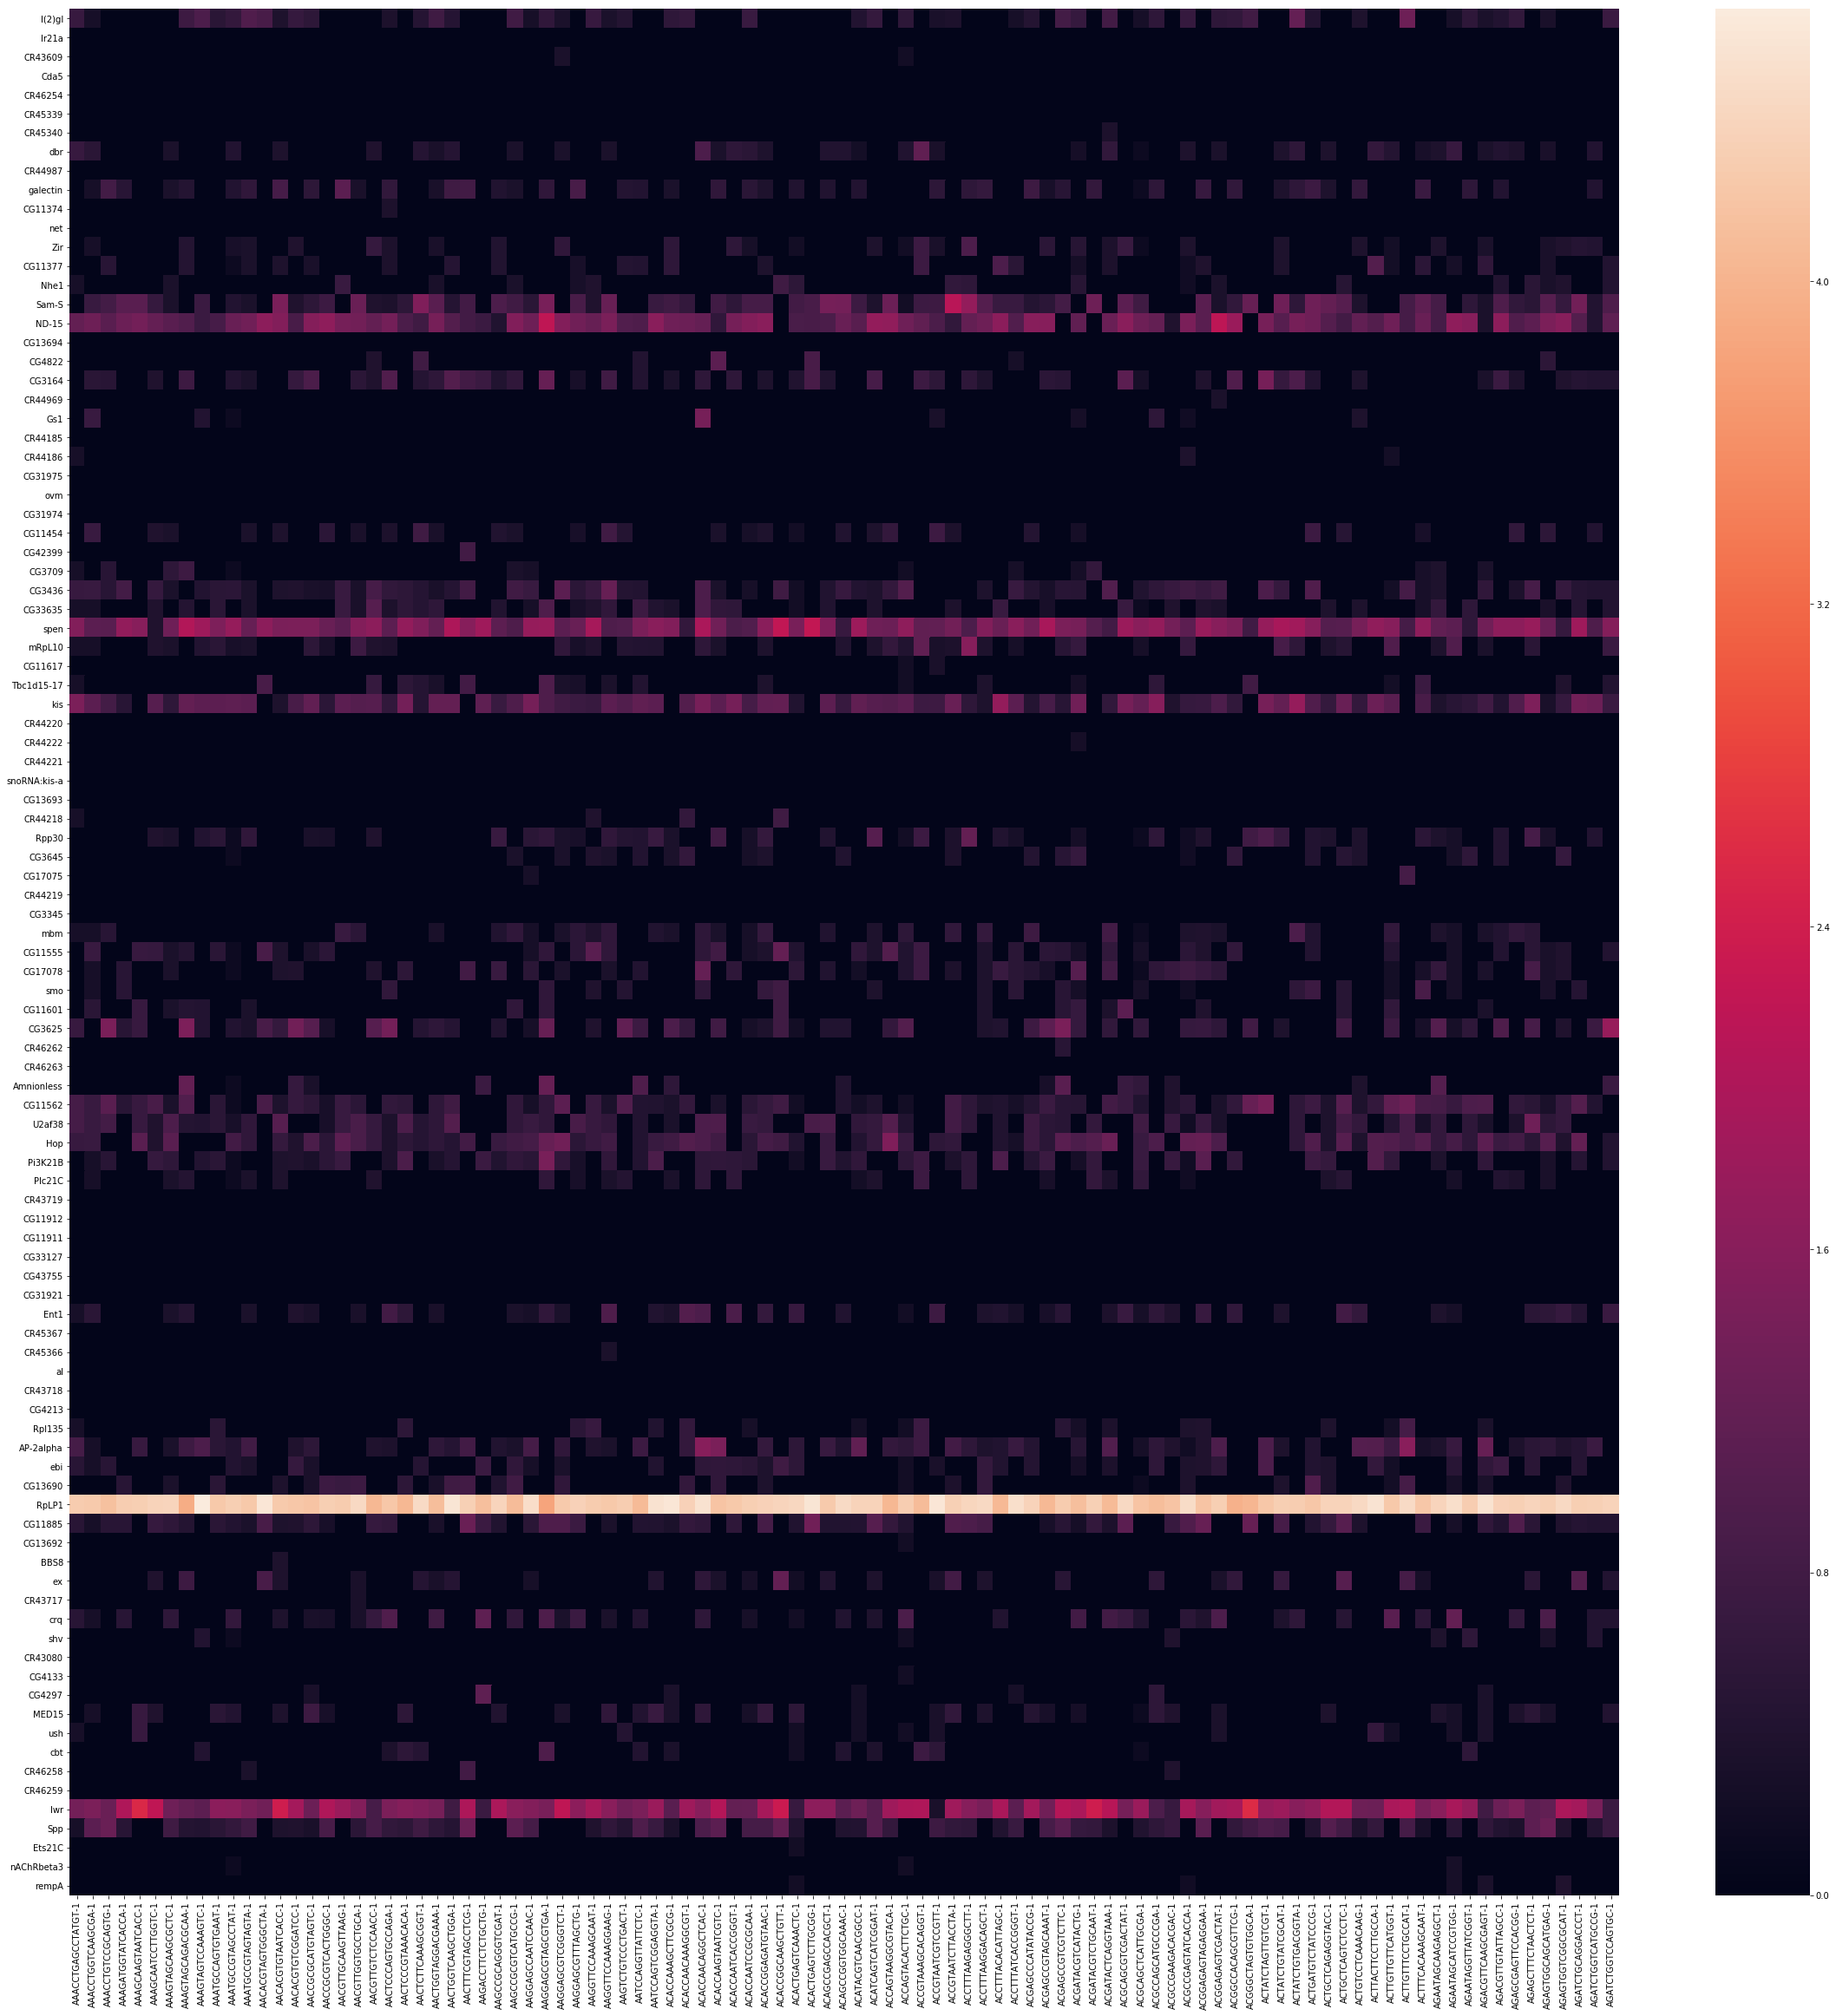

In [300]:
plt.figure(figsize=(40, 40))
sns.heatmap(combined_transformed.iloc[1:100, 1:100])

In [301]:
combined_transformed.shape

(17433, 7807)

In [ ]:
plt.bar(np.arange(len(filtered_lengths)), [x[0] for x in filtered_lengths.values()])

In [266]:
[x[0] for x in filtered_lengths.values()]

[753, 1178, 1526, 1294, 1524, 1252, 1697]

In [250]:
nGene_wt1 = df_wt1[df_wt1 > 0].count(axis = 0)

In [251]:
percent_mito_5percent_wt1 = percent_mito_wt1<0.05

In [252]:
percent_nGene_5000_wt1 = nGene_wt1<5000

In [253]:
df_filtered_wt1 = df_wt1.loc[:, percent_mito_5percent_wt1 & percent_nGene_5000_wt1]

In [254]:
filtered_data_frames['wt1'] = df_filtered

In [255]:
df_filtered_wt1.head()

,AAACCTGAGAGGACGG-1,AAACCTGAGCCTATGT-1,AAACCTGGTCAAGCGA-1,AAACCTGTCCGCAGTG-1,AAAGATGGTATCACCA-1,AAAGCAAGTAATCACC-1,AAAGCAATCCTTGGTC-1,AAAGTAGCAAGCGCTC-1,AAAGTAGCAGACGCAA-1,AAAGTAGTCCAAAGTC-1,...,TTGCGTCCAGCCACCA-1,TTGGAACAGTGTTAGA-1,TTGGAACGTGGTCTCG-1,TTGGAACTCCTTCAAT-1,TTGGAACTCTGCGACG-1,TTGTAGGCAGACACTT-1,TTTACTGAGAAGAAGC-1,TTTATGCGTAGAAGGA-1,TTTGCGCAGTACGCGA-1,TTTGGTTGTCCCTACT-1
CG11023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
l(2)gl,1,3,1,0,0,0,0,0,2,3,...,3,0,4,0,0,2,2,7,2,1
Ir21a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CR43609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Cda5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Text(0.5,0.98,u'wt2 filtered')

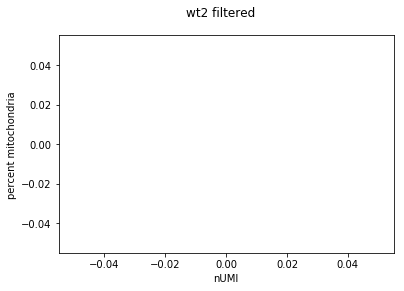

In [166]:
plt.scatter(nUMI, percent_mito)
plt.xlabel('nUMI')
plt.ylabel('percent mitochondria')
plt.suptitle('wt2 filtered')

Text(0.5,0.98,u'wt1')

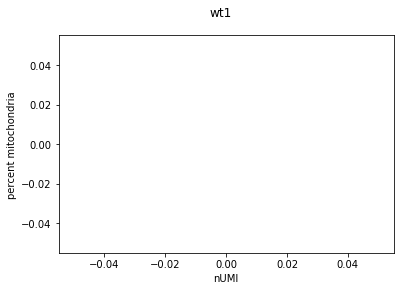

In [155]:
plt.scatter(nUMI, percent_mito)
plt.xlabel('nUMI')
plt.ylabel('percent mitochondria')

Text(0,0.5,u'nGene')

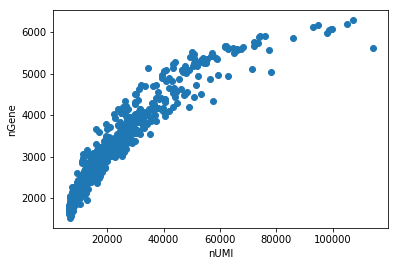

In [99]:
plt.scatter(nUMI, nGene)
plt.xlabel('nUMI')
plt.ylabel('nGene')

In [ ]:
df_filtered = df.loc[:, percent_mito_5percent & percent_nGene_5000]

In [79]:
mito_df = df[[x.__contains__("mt:") for x in df.index]]

mito_df.sum(axis=0)

AAACCTGAGAGGACGG-1     347
AAACCTGAGCCTATGT-1     818
AAACCTGGTCAAGCGA-1     629
AAACCTGTCCGCAGTG-1     261
AAAGATGGTATCACCA-1     332
AAAGCAAGTAATCACC-1     154
AAAGCAATCCTTGGTC-1     553
AAAGTAGCAAGCGCTC-1     459
AAAGTAGCAGACGCAA-1     306
AAAGTAGTCCAAAGTC-1     280
AAATGCCAGTGTGAAT-1     356
AAATGCCGTAGCCTAT-1    1249
AAATGCCGTAGTAGTA-1     560
AACACGTAGTGGGCTA-1     262
AACACGTGTAATCACC-1     426
AACACGTGTCGGATCC-1     435
AACCGCGCATGTAGTC-1     672
AACCGCGTCACTGGGC-1     877
AACGTTGCAAGTTAAG-1     164
AACGTTGGTGCCTGCA-1     615
AACGTTGTCTCCAACC-1     410
AACTCCCAGTGCCAGA-1     503
AACTCCCGTAAACACA-1     251
AACTCTTCAAAGCGGT-1     412
AACTGGTAGGACGAAA-1     467
AACTGGTCAAGCTGGA-1     342
AACTTTCGTAGCCTCG-1     157
AAGACCTTCTCTGCTG-1     194
AAGCCGCAGGGTCGAT-1     447
AAGCCGCGTCATGCCG-1     631
                      ... 
TTAGGACGTATTCTCT-1     302
TTAGGCAGTCTGGTCG-1     416
TTATGCTCAACCGCCA-1     292
TTATGCTCACCAACCG-1     485
TTCCCAGAGGACTGGT-1     445
TTCCCAGGTCGCTTTC-1     647
T

In [72]:
list([x.__contains__("mt:") for x in df.index])

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [75]:
mitogenes = df[[x.__contains__("mt:") for x in df.index]].index

Index([u'mt:tRNA:Ile-GAT', u'mt:tRNA:Gln-TTG', u'mt:tRNA:Met-CAT', u'mt:ND2',
       u'mt:tRNA:Trp-TCA', u'mt:tRNA:Cys-GCA', u'mt:tRNA:Tyr-GTA', u'mt:CoI',
       u'mt:tRNA:Leu-TAA', u'mt:CoII', u'mt:tRNA:Lys-CTT', u'mt:tRNA:Asp-GTC',
       u'mt:ATPase8', u'mt:ATPase6', u'mt:CoIII', u'mt:tRNA:Gly-TCC',
       u'mt:ND3', u'mt:tRNA:Ala-TGC', u'mt:tRNA:Arg-TCG', u'mt:tRNA:Asn-GTT',
       u'mt:tRNA:Ser-GCT', u'mt:tRNA:Glu-TTC', u'mt:tRNA:Phe-GAA', u'mt:ND5',
       u'mt:tRNA:His-GTG', u'mt:ND4', u'mt:ND4L', u'mt:tRNA:Thr-TGT',
       u'mt:tRNA:Pro-TGG', u'mt:ND6', u'mt:Cyt-b', u'mt:tRNA:Ser-TGA',
       u'mt:ND1', u'mt:tRNA:Leu-TAG', u'mt:lrRNA', u'mt:tRNA:Val-TAC',
       u'mt:srRNA'],
      dtype='object')

In [58]:
'4mt:6'.__contains__("mt:")

True

In [56]:
dir('h')

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__getslice__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmod__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_formatter_field_name_split',
 '_formatter_parser',
 'capitalize',
 'center',
 'count',
 'decode',
 'encode',
 'endswith',
 'expandtabs',
 'find',
 'format',
 'index',
 'isalnum',
 'isalpha',
 'isdigit',
 'islower',
 'isspace',
 'istitle',
 'isupper',
 'join',
 'ljust',
 'lower',
 'lstrip',
 'partition',
 'replace',
 'rfind',
 'rindex',
 'rjust',
 'rpartition',
 'rsplit',
 'rstrip',
 'split',
 'splitlines',
 'startswith',
 'strip',
 'swapcase',
 'title',
 'translate',
 'upper',
 'zfill']